In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.model import LSTMGenerator, UnitaryLSTMGenerator
from Path_Char.utils import AddTime
from torch.utils.data import DataLoader
import ml_collections
import seaborn as sns
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
sns.set()
torch.manual_seed(0)
device = 'cuda'

In [2]:
config = {'G_input_dim': 2,
          'G_hidden_dim': 32,
          'G_num_layers': 2,
          'G_output_dim': 3}
config = ml_collections.ConfigDict(config)

In [3]:
torch.manual_seed(0)
np.random.seed(0)
# number of path coordinates and number of time steps
D, L = 1, 3 

# experimental setup
repeats, n_samples, n, lambda_ = 100, 500, 5*1e5, 1e-5

# to store the sample paths from X_n and X
X = np.zeros((repeats, n_samples, 2, L, D)) 
X_n = np.zeros((repeats, n_samples, 2, L, D))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
omega_2 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X_n[:, :, :, 1, 0] = omega_1 * 1./n
X_n[:, :, :, 2, 0] = 0.1 * omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X[:, :, :, 2, 0] = 0.1 * omega_1

X = torch.tensor(X.reshape([-1, L, D]))
X_n = torch.tensor(X_n.reshape([-1, L, D]))

X = AddTime(X).to(torch.float)
X_n = AddTime(X_n).to(torch.float)

In [4]:
lie_degree_1 = 3
num_samples_1 = 1
input_size = 1
add_time = True

pcf_level_1 = char_func_path(num_samples=num_samples_1, 
                              hidden_size=lie_degree_1, 
                              input_dim=input_size, 
                              add_time=add_time, 
                              include_initial = False,
                              return_sequence=False)
pcf_level_1.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [5]:
with torch.no_grad():
    dev_X = pcf_level_1.unitary_development(X.to(device)).repeat([1, L, 1, 1])
    dev_X_n = pcf_level_1.unitary_development(X_n.to(device)).repeat([1, L, 1, 1])
    
train_X_dl = DataLoader(X, 128, shuffle=True)
train_X_dev_dl = DataLoader(dev_X, 128, shuffle=True)

train_X_n_dl = DataLoader(X_n, 128, shuffle=True)
train_X_n_dev_dl = DataLoader(dev_X_n, 128, shuffle=True)

In [6]:
regressor_for_X = UnitaryLSTMGenerator(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_X.to(device)

regressor_for_Y = UnitaryLSTMGenerator(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_Y.to(device)

UnitaryLSTMGenerator(
  (rnn): LSTM(2, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=18, bias=False)
  (activation): Tanh()
)

In [7]:
torch.norm(dev_X[0] - dev_X_n[0], dim=(1,2))

tensor([0.3180, 0.3180, 0.3180], device='cuda:0')

In [12]:
def train_regressor(regressor, iterations, X_dl, Y_dl):
    best_loss = 10000.
    regressor_optimizer = torch.optim.Adam(regressor.parameters(), betas=(0, 0.9), lr=0.002)
    regressor.train()
    for i in tqdm(range(iterations)):
        regressor_optimizer.zero_grad()
        batch_X = next(iter(X_dl))
        batch_X_dev = next(iter(Y_dl))
        reg_dev = regressor(batch_X, device)
    #     print(batch_Y.shape, reg_dev.shape)
        regressor_loss = torch.norm(reg_dev - batch_X_dev)
        if regressor_loss < best_loss:
            print("Loss updated: {}".format(regressor_loss), " at iteration {}".format(i))
#             with torch.no_grad():
#                 print(torch.norm(reg_dev - batch_X_dev, dim = [2,3]).mean(0))
            best_loss = regressor_loss
            trained_regressor = regressor

        regressor_loss.backward()
        regressor_optimizer.step()
    
    return trained_regressor

In [13]:
trained_regressor_X = train_regressor(regressor_for_X, 10000, train_X_dl, train_X_dev_dl)
trained_regressor_Y = train_regressor(regressor_for_Y, 10000, train_X_n_dl, train_X_n_dev_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 3.162274122238159  at iteration 0
Loss updated: 3.139366865158081  at iteration 5
Loss updated: 3.1363632678985596  at iteration 7
Loss updated: 3.120500326156616  at iteration 16
Loss updated: 3.1193628311157227  at iteration 62
Loss updated: 3.1165802478790283  at iteration 81
Loss updated: 3.1106419563293457  at iteration 118
Loss updated: 3.1049442291259766  at iteration 119
Loss updated: 3.0861306190490723  at iteration 165
Loss updated: 3.0805881023406982  at iteration 328
Loss updated: 3.062818765640259  at iteration 529
Loss updated: 3.0211753845214844  at iteration 837


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 28.931306838989258  at iteration 0
Loss updated: 28.089344024658203  at iteration 1
Loss updated: 27.21708106994629  at iteration 2
Loss updated: 26.373655319213867  at iteration 3
Loss updated: 25.442161560058594  at iteration 4
Loss updated: 24.486623764038086  at iteration 5
Loss updated: 23.52364158630371  at iteration 6
Loss updated: 22.399625778198242  at iteration 7
Loss updated: 21.26483726501465  at iteration 8
Loss updated: 20.16763687133789  at iteration 9
Loss updated: 18.998722076416016  at iteration 10
Loss updated: 17.731582641601562  at iteration 11
Loss updated: 16.709217071533203  at iteration 12
Loss updated: 15.701462745666504  at iteration 13
Loss updated: 14.865275382995605  at iteration 14
Loss updated: 14.111030578613281  at iteration 15
Loss updated: 13.530070304870605  at iteration 16
Loss updated: 13.179655075073242  at iteration 17
Loss updated: 12.793309211730957  at iteration 18
Loss updated: 12.526448249816895  at iteration 19
Loss updated: 

In [14]:
trained_regressor_X = regressor_for_X
trained_regressor_Y = regressor_for_Y

In [15]:
with torch.no_grad():
    exp_dev_X = trained_regressor_X(next(iter(train_X_dl)), device)
    exp_dev_Y = trained_regressor_Y(next(iter(train_X_n_dl)), device)

In [23]:
class expected_dev():
    
    def __init__(self, regressor_X, regressor_X_n, lie_degree_1, lie_degree_2, add_time = True, device = 'cuda'):
        super(expected_dev, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.device = device
        self.regressor_X = regressor_X
        self.regressor_X_n = regressor_X_n
        self.regressor_X.to(device)
        self.regressor_X_n.to(device)
        
        self.X_case_1 = torch.tensor([[[0.3333, 0.0000],
                                       [0.6667, 0.0000],
                                       [1.0000, 0.1000]]]).to(torch.float).to(device)
        self.X_case_2 = torch.tensor([[[0.3333, 0.0000],
                                       [0.6667, 0.0000],
                                       [1.0000, -0.1000]]]).to(torch.float).to(device)
        self.X_n_case_1 = torch.tensor([[[ 3.3333e-01, 0.0000e+00],
                                         [ 6.6667e-01, 2.0000e-06],
                                         [ 1.0000e+00, 1.0000e-01]]]).to(torch.float).to(device)
        self.X_n_case_2 = torch.tensor([[[ 3.3333e-01, 0.0000e+00],
                                         [ 6.6667e-01, -2.0000e-06],
                                         [ 1.0000e+00, -1.0000e-01]]]).to(torch.float).to(device)

        
        self.lie_degree_1 = lie_degree_1
        self.add_time = add_time
        self.num_samples_2 = 10
        self.lie_degree_2 = 5
        self.pcf_level_2 = char_func_path(num_samples=self.num_samples_2, 
                                      hidden_size=self.lie_degree_2, 
                                      input_dim=2*self.lie_degree_1**2, 
                                      add_time=add_time, 
                                      include_initial = False,
                                      return_sequence=False)
        self.pcf_level_2.to(device)
        
        
    def level_1_exp_dev(self):
        if self.add_time:
            dev_X_case_1 = self.pcf_level_1.unitary_development(self.X_case_1).squeeze()
            dev_X_case_2 = self.pcf_level_1.unitary_development(self.X_case_2).squeeze()
            dev_X_n_case_1 = self.pcf_level_1.unitary_development(self.X_n_case_1).squeeze()
            dev_X_n_case_2 = self.pcf_level_1.unitary_development(self.X_n_case_2).squeeze()
        else:
            dev_X_case_1 = self.pcf_level_1.unitary_development(self.X_case_1[:,:,1:]).squeeze()
            dev_X_case_2 = self.pcf_level_1.unitary_development(self.X_case_2[:,:,1:]).squeeze()
            dev_X_n_case_1 = self.pcf_level_1.unitary_development(self.X_n_case_1[:,:,1:]).squeeze()
            dev_X_n_case_2 = self.pcf_level_1.unitary_development(self.X_n_case_2[:,:,1:]).squeeze()
            
        exp_dev_X_case_1 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        exp_dev_X_case_2 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        exp_dev_X_n_case_1 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        exp_dev_X_n_case_2 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        
        exp_dev_X_case_1[0] = exp_dev_X_case_2[0] = exp_dev_X_case_1[1] = exp_dev_X_case_2[1] = (dev_X_case_1+dev_X_case_2)/2
        exp_dev_X_case_1[2] = dev_X_case_1
        exp_dev_X_case_2[2] = dev_X_case_2
        
        exp_dev_X_n_case_1[0] = exp_dev_X_n_case_1[0] = (dev_X_n_case_1+dev_X_n_case_1)/2
        exp_dev_X_n_case_1[1] = exp_dev_X_n_case_1[2] = dev_X_n_case_1
        exp_dev_X_n_case_2[1] = exp_dev_X_n_case_2[2] = dev_X_n_case_2
#         return exp_dev_X_case_1, exp_dev_X_case_2, exp_dev_X_n_case_1, exp_dev_X_n_case_2
        return exp_dev_X_case_1.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2]), \
               exp_dev_X_case_2.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2]), \
               exp_dev_X_n_case_1.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2]), \
               exp_dev_X_n_case_2.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2])
    
    def train_M(self, X_dl, X_n_dl):
        iterations = 10000
        best_loss = 0.
        
        char_2_optimizer = torch.optim.Adam(self.pcf_level_2.parameters(), betas=(0, 0.9), lr=0.002)
        
        print('start opitmize charateristics function')
        self.regressor_X.eval()
        self.regressor_X_n.eval()
        self.pcf_level_2.train()
        for i in tqdm(range(iterations)):
            
            X = next(iter(X_dl))
            X_n = next(iter(X_n_dl))
            with torch.no_grad():
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_Y = self.regressor_X_n(X_n, self.device).reshape([-1, X_n.shape[1], self.lie_degree_1**2])
                
                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)

            char_2_optimizer.zero_grad()
            char_loss = - self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
            if -char_loss > best_loss:
                print("Loss updated: {}".format(-char_loss))
                best_loss = -char_loss
            if i%100 == 0:
                print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
            char_loss.backward()
            char_2_optimizer.step()
    
    def evaluate(self, X_dl, X_n_dl):
        self.pcf_level_2.eval()
        self.regressor_X.eval()
        self.regressor_X_n.eval()
        repeats = 100
        MMD_1 = np.zeros((repeats))
        MMD_2 = np.zeros((repeats))
        with torch.no_grad():
            for i in tqdm(range(repeats)):
                X = next(iter(X_dl))
                X_n = next(iter(X_n_dl))
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_X_ = self.regressor_X(X_, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_Y = self.regressor_X_n(X_n, self.device).reshape([-1, X_n.shape[1], self.lie_degree_1**2])

                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)
                exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag],-1)
                
                MMD_1[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
                MMD_2[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
        return MMD_1, MMD_2

In [24]:
expected_devx = expected_dev(regressor_X = trained_regressor_X, regressor_X_n = trained_regressor_Y, lie_degree_1 = 3, lie_degree_2 = 5)

In [25]:
expected_devx.train_M(train_X_dl, train_X_n_dl)

start opitmize charateristics function


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 0.0002160395961254835
Iteration 0 :  loss = 0.0002160395961254835
Loss updated: 0.0002210951643064618
Loss updated: 0.00022420268214773387
Loss updated: 0.00022999921930022538
Loss updated: 0.00023461446107830852
Loss updated: 0.0002393151371506974
Loss updated: 0.00024248939007520676
Loss updated: 0.00024785668938420713
Loss updated: 0.0002502760908100754
Loss updated: 0.0002564701426308602
Loss updated: 0.00025748999905772507
Loss updated: 0.00026542835985310376
Loss updated: 0.0002717904280871153
Loss updated: 0.0002761941577773541
Loss updated: 0.0002815038897097111
Loss updated: 0.000290970376227051
Loss updated: 0.00029467284912243485
Loss updated: 0.0002977783151436597
Loss updated: 0.00030451113707385957
Loss updated: 0.0003087602963205427
Loss updated: 0.0003159192856401205
Loss updated: 0.00032033026218414307
Loss updated: 0.00032665111939422786
Loss updated: 0.00033168462687171996
Loss updated: 0.0003383906732778996
Loss updated: 0.000342865678248927
Loss updat

Loss updated: 0.0037375842221081257
Loss updated: 0.003769243136048317
Loss updated: 0.003814749186858535
Loss updated: 0.0038416662719100714
Loss updated: 0.00384295592084527
Loss updated: 0.0038631947245448828
Loss updated: 0.003918410744518042
Loss updated: 0.003969096578657627
Loss updated: 0.004020929802209139
Loss updated: 0.0040223184041678905
Loss updated: 0.00406419625505805
Loss updated: 0.004084039479494095
Loss updated: 0.004120244178920984
Loss updated: 0.004152445122599602
Loss updated: 0.004170700442045927
Loss updated: 0.004213613923639059
Loss updated: 0.004260411951690912
Loss updated: 0.0043234871700406075
Loss updated: 0.004378496203571558
Loss updated: 0.004380247555673122
Loss updated: 0.0044111586175858974
Loss updated: 0.00443793460726738
Loss updated: 0.00450394069775939
Loss updated: 0.004505101125687361
Loss updated: 0.004555815365165472
Loss updated: 0.004575999919325113
Loss updated: 0.004606067668646574
Loss updated: 0.004674545954912901
Loss updated: 0.00

Loss updated: 0.021382756531238556
Loss updated: 0.021403728052973747
Loss updated: 0.021519294008612633
Loss updated: 0.02174975723028183
Loss updated: 0.02195269800722599
Loss updated: 0.02209267020225525
Loss updated: 0.02215275540947914
Loss updated: 0.022358452901244164
Loss updated: 0.02239888347685337
Loss updated: 0.022547082975506783
Loss updated: 0.022953856736421585
Loss updated: 0.02301529236137867
Loss updated: 0.023127039894461632
Loss updated: 0.02313125692307949
Loss updated: 0.02359100617468357
Loss updated: 0.0237306896597147
Loss updated: 0.02403721958398819
Iteration 700 :  loss = 0.02395537681877613
Loss updated: 0.024097992107272148
Loss updated: 0.024354206398129463
Loss updated: 0.024534789845347404
Loss updated: 0.02476860024034977
Loss updated: 0.024929707869887352
Loss updated: 0.025221366435289383
Loss updated: 0.025336269289255142
Loss updated: 0.025586986914277077
Loss updated: 0.025982066988945007
Loss updated: 0.0261995792388916
Loss updated: 0.026439279

Loss updated: 0.09010757505893707
Loss updated: 0.09030797332525253
Loss updated: 0.09086912125349045
Loss updated: 0.09127777069807053
Loss updated: 0.09132079780101776
Loss updated: 0.09210363775491714
Loss updated: 0.09244926273822784
Loss updated: 0.09258200973272324
Loss updated: 0.09316293895244598
Loss updated: 0.09371288865804672
Loss updated: 0.09484899789094925
Loss updated: 0.095830537378788
Loss updated: 0.09723105281591415
Loss updated: 0.09738241881132126
Iteration 1500 :  loss = 0.09738241881132126
Loss updated: 0.09818508476018906
Loss updated: 0.09936566650867462
Loss updated: 0.09947392344474792
Loss updated: 0.09976399689912796
Loss updated: 0.10035772621631622
Loss updated: 0.10047204792499542
Loss updated: 0.10055103152990341
Loss updated: 0.10149319469928741
Loss updated: 0.10270406305789948
Loss updated: 0.10340899229049683
Loss updated: 0.10499858856201172
Loss updated: 0.10602877289056778
Loss updated: 0.10637972503900528
Loss updated: 0.1065259724855423
Loss u

Loss updated: 0.291748583316803
Loss updated: 0.29463523626327515
Loss updated: 0.29569125175476074
Loss updated: 0.2957826852798462
Loss updated: 0.2980058789253235
Iteration 2700 :  loss = 0.29537397623062134
Loss updated: 0.29838845133781433
Loss updated: 0.3005170524120331
Loss updated: 0.30100658535957336
Loss updated: 0.30162855982780457
Loss updated: 0.3035299479961395
Loss updated: 0.3069191873073578
Loss updated: 0.30958208441734314
Loss updated: 0.3097677230834961
Loss updated: 0.3117290139198303
Loss updated: 0.31247639656066895
Loss updated: 0.31292304396629333
Loss updated: 0.31441032886505127
Loss updated: 0.316891610622406
Loss updated: 0.31781595945358276
Loss updated: 0.3183262050151825
Loss updated: 0.3185504376888275
Iteration 2800 :  loss = 0.3161984980106354
Loss updated: 0.3196217119693756
Loss updated: 0.3201466202735901
Loss updated: 0.320936381816864
Loss updated: 0.3235502243041992
Loss updated: 0.3245088458061218
Loss updated: 0.3260311782360077
Loss updated:

Loss updated: 0.8034106492996216
Loss updated: 0.8129882216453552
Loss updated: 0.8179643750190735
Loss updated: 0.8196719288825989
Loss updated: 0.8199213147163391
Loss updated: 0.8266982436180115
Iteration 4600 :  loss = 0.8024932742118835
Loss updated: 0.8275171518325806
Loss updated: 0.8325519561767578
Loss updated: 0.8331672549247742
Loss updated: 0.8367410898208618
Loss updated: 0.847406804561615
Loss updated: 0.8527292609214783
Loss updated: 0.8551360964775085
Loss updated: 0.8555019497871399
Iteration 4700 :  loss = 0.841958224773407
Loss updated: 0.8583943247795105
Loss updated: 0.8696853518486023
Loss updated: 0.8748188018798828
Loss updated: 0.8757047653198242
Loss updated: 0.8778425455093384
Loss updated: 0.8785671591758728
Loss updated: 0.8803600668907166
Loss updated: 0.8818249702453613
Loss updated: 0.8832859396934509
Loss updated: 0.8863975405693054
Loss updated: 0.886537492275238
Loss updated: 0.8918533325195312
Iteration 4800 :  loss = 0.886084258556366
Loss updated: 

Loss updated: 1.8881113529205322
Loss updated: 1.8889316320419312
Loss updated: 1.8957903385162354
Loss updated: 1.8998132944107056
Loss updated: 1.9007090330123901
Loss updated: 1.9044857025146484
Loss updated: 1.9087399244308472
Iteration 7200 :  loss = 1.8627156019210815
Loss updated: 1.9110180139541626
Loss updated: 1.9137791395187378
Loss updated: 1.916433334350586
Loss updated: 1.938628077507019
Loss updated: 1.940089225769043
Loss updated: 1.94264817237854
Loss updated: 1.9475011825561523
Loss updated: 1.9601078033447266
Loss updated: 1.9623510837554932
Iteration 7300 :  loss = 1.9040329456329346
Loss updated: 1.965406060218811
Loss updated: 1.9787572622299194
Loss updated: 1.9918817281723022
Loss updated: 1.9974037408828735
Loss updated: 2.019160270690918
Loss updated: 2.0202298164367676
Iteration 7400 :  loss = 1.989463448524475
Loss updated: 2.034543514251709
Loss updated: 2.0468997955322266
Loss updated: 2.0529208183288574
Loss updated: 2.055577039718628
Iteration 7500 :  lo

In [26]:
MMD_1, MMD_2 = expected_devx.evaluate(train_X_dl, train_X_n_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
expected_devx.pcf_level_2.eval()
expected_devx.regressor_X.eval()
expected_devx.regressor_X_n.eval()
repeats = 100
MMD_1 = np.zeros((repeats))
MMD_2 = np.zeros((repeats))
with torch.no_grad():
    for i in range(repeats):
        X = next(iter(train_X_dl))
        X_n = next(iter(train_X_n_dl))
        X_ = next(iter(train_X_dl))
        
        exp_dev_X = expected_devx.regressor_X(X, expected_devx.device).reshape([-1, X.shape[1], expected_devx.lie_degree_1**2])
        exp_dev_X_ = expected_devx.regressor_X(X_, expected_devx.device).reshape([-1, X.shape[1], expected_devx.lie_degree_1**2])
        exp_dev_Y = expected_devx.regressor_X_n(X_n, expected_devx.device).reshape([-1, X_n.shape[1], expected_devx.lie_degree_1**2])

        exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
        exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)
        exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag],-1)
        MMD_1[i] = expected_devx.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
        MMD_2[i] = expected_devx.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)


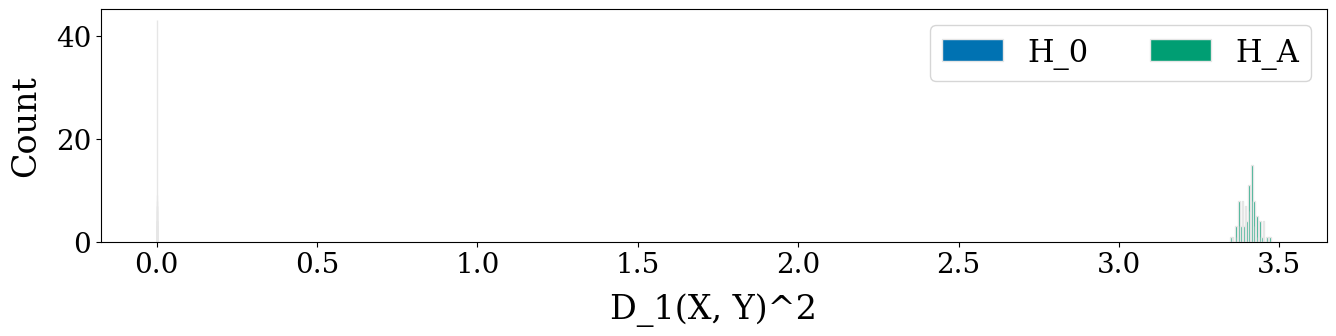

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.hist(MMD_1, bins=25, label='H_0',edgecolor='#E6E6E6')
ax.hist(MMD_2, bins=25, label='H_A',edgecolor='#E6E6E6')

ax.legend(loc='upper right', ncol=2, fontsize=22)
ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
ax.set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

In [81]:
print(exp_dev_X.shape)
print(exp_dev_Y.shape)

torch.Size([128, 3, 3, 3])
torch.Size([128, 3, 3, 3])


In [82]:
exp_dev_X = exp_dev_X.reshape([-1, 3, 3**2])
exp_dev_Y = exp_dev_Y.reshape([-1, 3, 3**2])

exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)

In [202]:
expected_devx = expected_dev(3, 3)

In [203]:
MMD_1, MMD_2 = expected_devx.train_m_and_M()

start opitmize charateristics function


  0%|          | 0/100 [00:00<?, ?it/s]

Loss updated: 0.00958927907049656
Iteration 0 :  loss = 0.00958927907049656
Loss updated: 0.01289910078048706
Loss updated: 0.013208650052547455
Loss updated: 0.013815561309456825
Loss updated: 0.01783725619316101
Loss updated: 0.025466570630669594
Loss updated: 0.02718450501561165
Loss updated: 0.031856730580329895
Loss updated: 0.03542101010680199
Loss updated: 0.0403374508023262
Loss updated: 0.044821154326200485
Loss updated: 0.04591923579573631
Loss updated: 0.046977076679468155
Loss updated: 0.04904935136437416
Loss updated: 0.049543123692274094
Loss updated: 0.05644277483224869
Loss updated: 0.059887100011110306
Loss updated: 0.060746580362319946
Loss updated: 0.06861215829849243
Loss updated: 0.07545744627714157
Loss updated: 0.08133150637149811
Loss updated: 0.09119126200675964
Loss updated: 0.09300529211759567
Loss updated: 0.09448663145303726
Loss updated: 0.0963139757514
Loss updated: 0.1057518944144249
Loss updated: 0.12693224847316742


No handles with labels found to put in legend.


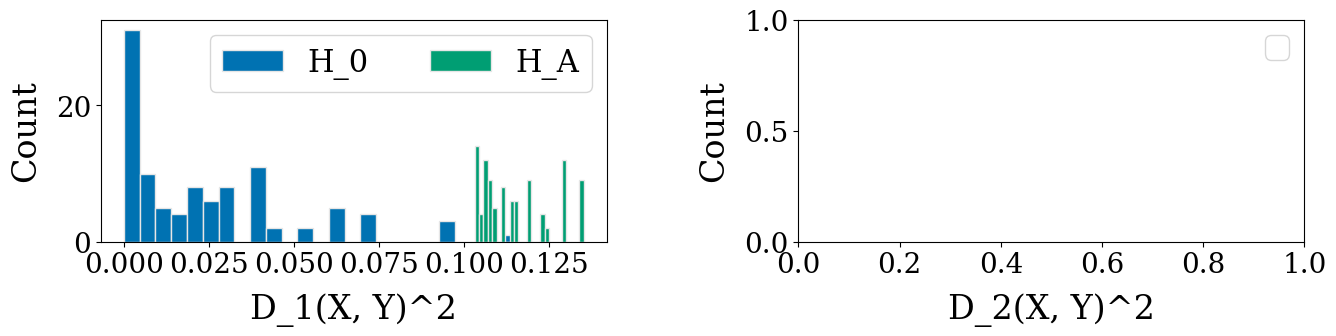

In [204]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(MMD_1, bins=25, label='H_0',edgecolor='#E6E6E6')
ax[0].hist(MMD_2, bins=25, label='H_A',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right', ncol=2, fontsize=22)
ax[0].set_xlabel('D_1(X, Y)^2', labelpad=10)
ax[0].set_ylabel('Count', labelpad=10)

# ax[1].hist(MMD_2, bins=25, label='H_0', edgecolor='#E6E6E6')
# ax[1].hist(MMD_2[:,1], bins=25, label='H_A', edgecolor='#E6E6E6')

ax[1].legend(loc='upper right', ncol=2, fontsize=22)
ax[1].set_xlabel('D_2(X, Y)^2', labelpad=10)
ax[1].set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

In [134]:
def HS_norm(X: torch.tensor, Y: torch.Tensor):
    """_summary_

    Args:
        X (torch.Tensor): (C,m,m) complexed valued
    """
    if len(X.shape) == 4:

        m = X.shape[-1]
        X = X.reshape(-1, m, m)

    else:
        pass
    D = torch.bmm(X, torch.conj(Y).permute(0, 2, 1))
    return ((torch.einsum('bii->b', D)).mean().real)

### Traing the second pcf

In [33]:
# Training set

list_X, list_Y = compute_true_expected_dev(X[:,:,0,:,:], X_n[:,:,0,:,:], pcf_level_1, x001, xn001, dv_x001, dv_x00_1, dv_xn001, dv_xn00_1)
train_X = list_X[0].reshape([-1, L, lie_degree_1**2]).detach()
train_Y = list_Y[0].reshape([-1, L, lie_degree_1**2]).detach()

train_X_dl = DataLoader(train_X, 128, shuffle=True)
train_Y_dl = DataLoader(train_Y, 128, shuffle=True)

# Test set 
list_X_, list_Y_ = compute_true_expected_dev(X[:,:,1,:,:], X_n[:,:,1,:,:], pcf_level_1, x001, xn001, dv_x001, dv_x00_1, dv_xn001, dv_xn00_1)

In [36]:
def train_pcf(train_X_dl, train_Y_dl, pcf):
    iterations = 1000

    char_optimizer = torch.optim.Adam(
            pcf.parameters(), betas=(0, 0.9), lr=0.002)

    print('start opitmize charateristics function')
    pcf.train()
    for i in tqdm(range(iterations)):
        X_ = next(iter(train_X_dl))
        Y_ = next(iter(train_Y_dl))
        char_optimizer.zero_grad()
        char_loss = - pcf.distance_measure(
                X_, Y_, Lambda=0)
        if i%100 == 0:
            print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
        char_loss.backward()
        char_optimizer.step()
    return pcf

In [37]:
num_samples_2 = 100
lie_degree_2 = 4
pcf_level_2 = char_func_path(num_samples=num_samples_2, 
                              hidden_size=lie_degree_2, 
                              input_dim=lie_degree_1**2, 
                              add_time=add_time, 
                              include_initial = False)
pcf_level_2.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)